In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pylab
from scipy.stats import boxcox, probplot
from scipy.special import inv_boxcox

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, collect_list, col

In [3]:
sp = SparkSession.builder.appName("Check visuals").getOrCreate()
sp

22/08/25 03:10:46 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.28.49.50 instead (on interface eth0)
22/08/25 03:10:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/25 03:10:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/25 03:10:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/25 03:10:50 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Get data

To visualize only on the training data and not look at the test data to estimate and understand trends

In [4]:
bikes = sp.read.parquet("../data/processed/bikes_train/")
bikes.show(3)
bikes.count()

+----+-----+---+--------+------------+------------+-----------+-------------+----------+---------------+-----+-----------+---------+--------+----------+---------+--------+-------------+
|year|month|day|time_bin|PULocationID|DOLocationID|day_of_week|trip_duration|peak_hours|weather_pattern|count|Temperature|Dew Point|Humidity|Wind Speed|Wind Gust|Pressure|Precipitation|
+----+-----+---+--------+------------+------------+-----------+-------------+----------+---------------+-----+-----------+---------+--------+----------+---------+--------+-------------+
|2021|    7|195|      18|          43|          48|          4|         1598|         1|              1| 1215|       85.0|     70.0|    61.0|      12.0|      0.0|    30.1|          0.0|
|2021|    7|195|      18|         140|         137|          4|         1457|         1|              1| 1215|       85.0|     70.0|    61.0|      12.0|      0.0|    30.1|          0.0|
|2021|    7|207|      16|         231|         246|          2|       

3205858

In [5]:
taxis = sp.read.parquet("../data/processed/taxis_train/")
taxis.show(3)
taxis.count()

+----+-----+---+--------+------------+------------+-----------+-------------+----------+---------------+-----+-----------+---------+--------+----------+---------+--------+-------------+
|year|month|day|time_bin|PULocationID|DOLocationID|day_of_week|trip_duration|peak_hours|weather_pattern|count|Temperature|Dew Point|Humidity|Wind Speed|Wind Gust|Pressure|Precipitation|
+----+-----+---+--------+------------+------------+-----------+-------------+----------+---------------+-----+-----------+---------+--------+----------+---------+--------+-------------+
|2021|   12|361|      10|          68|         170|          2|          834|         1|              0| 2114|       36.0|     21.0|    55.0|      10.0|      0.0|    30.1|          0.0|
|2021|   12|361|      10|         161|         234|          2|          389|         1|              0| 2114|       36.0|     21.0|    55.0|      10.0|      0.0|    30.1|          0.0|
|2021|   12|361|      10|         107|         224|          2|       

15050936

#### Average trip duration during a 24 hour period

The following graphs find the average trip distance for a given starting hour. This may help interpret either what the users are doing or the traffic

In [6]:
avg_taxi_time_per_day = taxis.groupBy("time_bin").avg("trip_duration")
avg_taxi_time_per_day_pd = avg_taxi_time_per_day.toPandas()
avg_taxi_time_per_day_pd.head()

,time_bin,avg(trip_duration)
0,12,905.756325
1,22,651.059985
2,1,619.162540
3,13,887.472966
4,6,842.413684


In [7]:
avg_bike_time_per_day = bikes.groupBy("time_bin").avg("trip_duration")
avg_bike_time_per_day_pd = avg_bike_time_per_day.toPandas()
avg_bike_time_per_day_pd.head()

,time_bin,avg(trip_duration)
0,12,869.124492
1,22,887.358642
2,1,911.429745
3,13,880.392545
4,16,912.104763


In [8]:
# Get average by minutes
avg_taxi_time_per_day_pd["avg(trip_duration) by 60"] = avg_taxi_time_per_day_pd["avg(trip_duration)"] / 60
avg_bike_time_per_day_pd["avg(trip_duration) by 60"] = avg_bike_time_per_day_pd["avg(trip_duration)"] / 60
avg_bike_time_per_day_pd.head()

,time_bin,avg(trip_duration),avg(trip_duration) by 60
0,12,869.124492,14.485408
1,22,887.358642,14.789311
2,1,911.429745,15.190496
3,13,880.392545,14.673209
4,16,912.104763,15.201746


In [9]:
# Set styles
sns.set_style("whitegrid")
sns.set_palette("summer")

<AxesSubplot:xlabel='time_bin', ylabel='avg(trip_duration) by 60'>

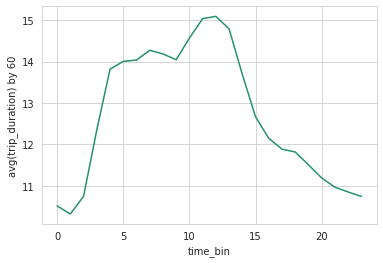

In [10]:
sns.lineplot(x="time_bin", y="avg(trip_duration) by 60", data=avg_taxi_time_per_day_pd)

<AxesSubplot:xlabel='time_bin', ylabel='avg(trip_duration) by 60'>

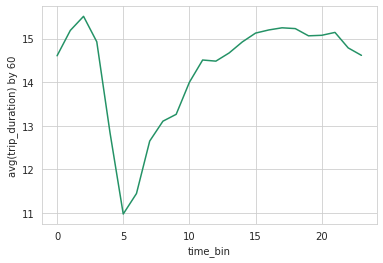

In [11]:
sns.lineplot(x="time_bin", y="avg(trip_duration) by 60", data=avg_bike_time_per_day_pd)

In [12]:
avg_bike_time_per_day_pd["hue"] = 0
avg_taxi_time_per_day_pd["hue"] = 1
merged = pd.concat([avg_bike_time_per_day_pd.drop("avg(trip_duration)", axis=1), avg_taxi_time_per_day_pd.drop("avg(trip_duration)", axis=1)])

Text(13.1, -0.05, '1 pm')

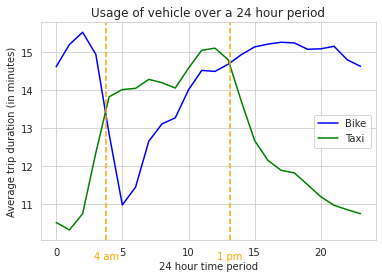

In [13]:
ax = sns.lineplot(data=merged.reset_index(drop=True), x="time_bin", y="avg(trip_duration) by 60", hue="hue", palette=["b", "g"], linestyle="-")
ax.legend(["Bike", "Taxi"])

ax.set_xlabel("24 hour time period")
ax.set_ylabel("Average trip duration (in minutes)")
ax.set_title("Usage of vehicle over a 24 hour period")

ax.axvline(3.8, color='orange', ls="--")
ax.text(3.8, -.05, "4 am", color="orange", transform=ax.get_xaxis_transform(), ha='center', va='top')
ax.axvline(13.1, color='orange', ls="--")
ax.text(13.1, -.05, "1 pm", color="orange", transform=ax.get_xaxis_transform(), ha='center', va='top')
# 4 am to 1 pm

## Seasonality of bike trips

It was particularly important to include weather into the data since there was a certain seasonality in the bike trips as seen below. It outlines that bikes were used quite less in the winter and snowy periods as compared to summer which is fair assumption to make due to cold weather, blockage of footpaths due to snowfall, and better alternate options like a warm ride in the taxi

In [14]:
bikes.show(3)

+----+-----+---+--------+------------+------------+-----------+-------------+----------+---------------+-----+-----------+---------+--------+----------+---------+--------+-------------+
|year|month|day|time_bin|PULocationID|DOLocationID|day_of_week|trip_duration|peak_hours|weather_pattern|count|Temperature|Dew Point|Humidity|Wind Speed|Wind Gust|Pressure|Precipitation|
+----+-----+---+--------+------------+------------+-----------+-------------+----------+---------------+-----+-----------+---------+--------+----------+---------+--------+-------------+
|2021|    7|195|      18|          43|          48|          4|         1598|         1|              1| 1215|       85.0|     70.0|    61.0|      12.0|      0.0|    30.1|          0.0|
|2021|    7|195|      18|         140|         137|          4|         1457|         1|              1| 1215|       85.0|     70.0|    61.0|      12.0|      0.0|    30.1|          0.0|
|2021|    7|207|      16|         231|         246|          2|       

In [15]:
count_trips = bikes.filter(col("year") == 2021).groupBy("day").count().toPandas()
count_trips.head()

,day,count
0,251,11273
1,193,9116
2,211,11312
3,183,7731
4,210,7649


In [16]:
len(count_trips)
# Because no weekends

260

Text(330, -0.1, 'cold')

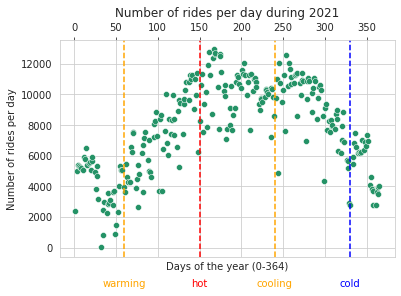

In [17]:
#ax = plt.subplot()
plt.xticks(rotation=45)
count_trips.sort_values(by="day", inplace=True)

ax = sns.scatterplot(x=count_trips["day"], y=count_trips["count"])

ax.set_xlabel("Days of the year (0-364)")
ax.set_ylabel("Number of rides per day")
ax.set_title("Number of rides per day during 2021")
ax.xaxis.tick_top()

ax.axvline(60, color='orange', ls="--")
ax.text(60, -.1, "warming", color="orange", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvline(150, color='red', ls="--")
ax.text(150, -.1, "hot", color="red", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvline(240, color='orange', ls="--")
ax.text(240, -.1, "cooling", color="orange", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvline(330, color='blue', ls="--")
ax.text(330, -.1, "cold", color="blue", transform=ax.get_xaxis_transform(), ha='center', va='top')

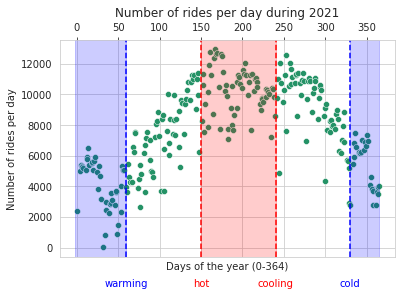

22/08/25 04:40:06 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 283458 ms exceeds timeout 120000 ms
22/08/25 04:40:07 WARN SparkContext: Killing executors is not supported by current scheduler.


In [26]:
#ax = plt.subplot()
plt.xticks(rotation=45)
count_trips.sort_values(by="day", inplace=True)

ax = sns.scatterplot(x=count_trips["day"], y=count_trips["count"])

ax.set_xlabel("Days of the year (0-364)")
ax.set_ylabel("Number of rides per day")
ax.set_title("Number of rides per day during 2021")
ax.xaxis.tick_top()

ax.axvline(60, color='blue', ls="--")
ax.text(60, -.1, "warming", color="blue", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvline(150, color='red', ls="--")
ax.text(150, -.1, "hot", color="red", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvline(240, color='red', ls="--")
ax.text(240, -.1, "cooling", color="red", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvline(330, color='blue', ls="--")
ax.text(330, -.1, "cold", color="blue", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvspan(-2, 60, alpha=0.2, color='b')
#ax.axvspan(60, 150, alpha=0.2, color='orange')
ax.axvspan(150, 240, alpha=0.2, color='r')
#ax.axvspan(240, 330, alpha=0.2, color='orange')
ax.axvspan(330, 365, alpha=0.2, color='b')

In [1]:
# Check

Text(330, -0.1, 'cold')

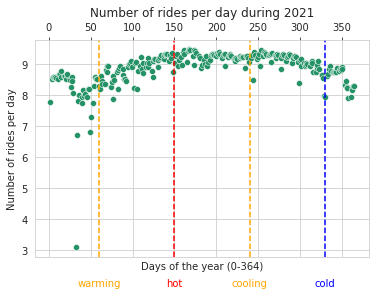

In [17]:
#ax = plt.subplot()
plt.xticks(rotation=45)
count_trips.sort_values(by="day", inplace=True)

ax = sns.scatterplot(x=count_trips["day"], y=np.log(count_trips["count"]))

ax.set_xlabel("Days of the year (0-364)")
ax.set_ylabel("Number of rides per day")
ax.set_title("Number of rides per day during 2021")
ax.xaxis.tick_top()

ax.axvline(60, color='orange', ls="--")
ax.text(60, -.1, "warming", color="orange", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvline(150, color='red', ls="--")
ax.text(150, -.1, "hot", color="red", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvline(240, color='orange', ls="--")
ax.text(240, -.1, "cooling", color="orange", transform=ax.get_xaxis_transform(), ha='center', va='top')

ax.axvline(330, color='blue', ls="--")
ax.text(330, -.1, "cold", color="blue", transform=ax.get_xaxis_transform(), ha='center', va='top')

In [18]:
count_trips_taxi = taxis.filter(col("year") == 2021).groupBy("day").count().toPandas()
count_trips_taxi.head()

,day,count
0,243,40932
1,362,34413
2,300,55292
3,236,40766
4,336,60495


Text(0.5, 1.0, 'Number of taxi rides per day during 2021')

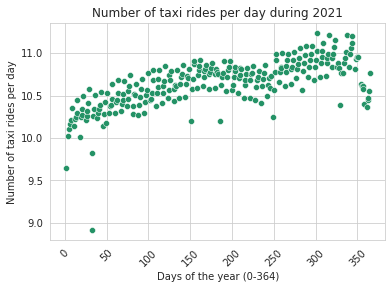

In [19]:
#ax = plt.subplot()
plt.xticks(rotation=45)
count_trips_taxi.sort_values(by="day", inplace=True)

ax = sns.scatterplot(x=count_trips_taxi["day"], y=np.log(count_trips_taxi["count"]))

ax.set_xlabel("Days of the year (0-364)")
ax.set_ylabel("Number of taxi rides per day")
ax.set_title("Number of taxi rides per day during 2021")

In [20]:
count_trips_taxi[np.log(count_trips_taxi["count"]) < 10]

,day,count
227,1,15415
210,32,7411
212,33,18420


<AxesSubplot:>

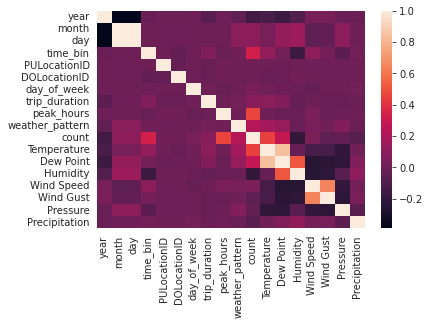

In [21]:
sns.heatmap(bikes.sample(0.1).toPandas().corr())

In [22]:
taxi_sample = taxis.sample(0.05).toPandas().dropna()
bike_sample = bikes.sample(0.05).toPandas().dropna()

<AxesSubplot:>

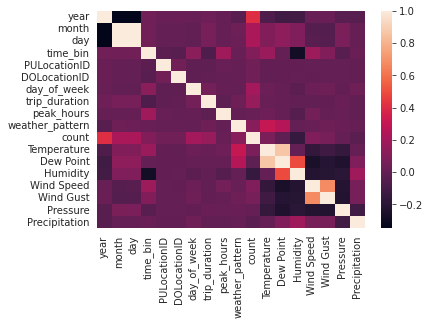

In [23]:
sns.heatmap(taxi_sample.corr())

### Building relationships

 The following plots try to check and build linear relationships with the help of transformations

<AxesSubplot:xlabel='trip_duration', ylabel='Precipitation'>

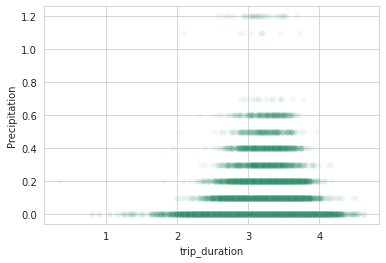

In [24]:
sns.scatterplot(x = np.log(np.sqrt(taxi_sample["trip_duration"])), y = taxi_sample["Precipitation"], alpha=0.05)

#### Transforming to normal distribution - trip distance

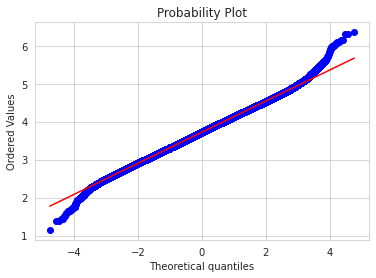

In [25]:
probplot(np.power(taxi_sample["trip_duration"], 0.20), dist="norm", plot=pylab)
pylab.show()

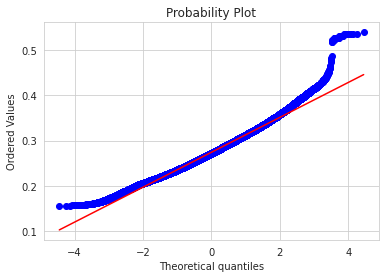

In [26]:
probplot(np.power(bike_sample["trip_duration"], -0.20), dist="norm", plot=pylab)
pylab.show()

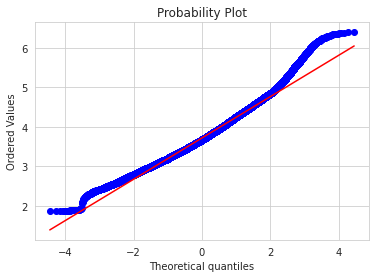

In [27]:
probplot(np.power(bike_sample["trip_duration"], 0.20), dist="norm", plot=pylab)
pylab.show()

Comparing transformations for both taxis and bikes

Bike, Taxi
-0.014819731955757118 0.2016885606746624


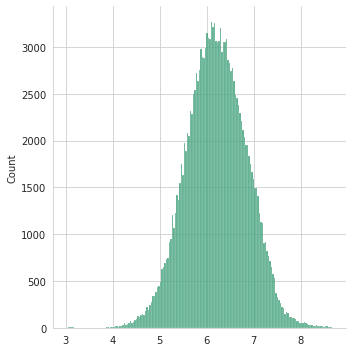

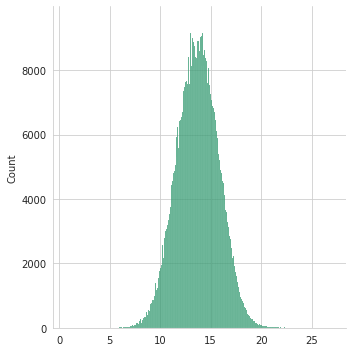

In [28]:
dist_bike, lambda_bike = boxcox(bike_sample["trip_duration"])
dist_taxi, lambda_taxi = boxcox(taxi_sample["trip_duration"])

#fig, axes = plt.subplots(1, 2, sharey=True)
sns.displot(dist_bike)
#axes[0].set_title("Adjusted for normal bike duration")
sns.displot(dist_taxi)
#axes[1].set_title("Adjusted for normal bike duration")

print("Bike, Taxi")
print(lambda_bike, lambda_taxi)

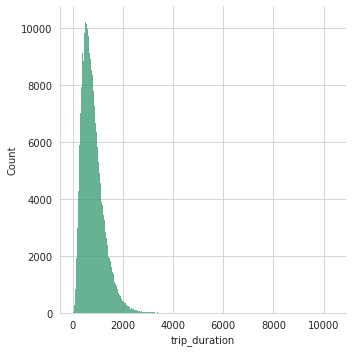

In [29]:
# Checking box plot with non-transformed array
sns.displot(taxi_sample["trip_duration"])
# Heavy right skewed to normal distribution

Using a boxcox plot for the other features

<AxesSubplot:xlabel='month', ylabel='trip_duration'>

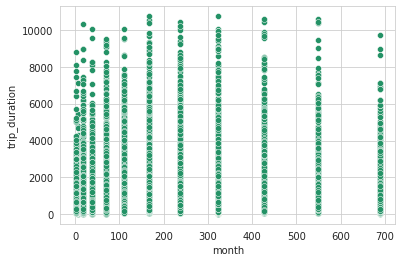

In [30]:
# Comparing the effect of month on bikes vs taxis
sns.scatterplot(x = bike_sample["month"] ** (2.63), y=bike_sample["trip_duration"])

In [31]:
bike_sample.head()

,year,month,day,time_bin,PULocationID,DOLocationID,day_of_week,trip_duration,peak_hours,weather_pattern,count,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Precipitation
0,2021,7,195,18,74,141,4,1740,1,1,1215,85.0,70.0,61.0,12.0,0.0,30.1,0.0
1,2021,7,204,18,238,48,6,1728,1,1,802,79.0,54.0,42.0,9.0,0.0,30.0,0.0
2,2021,7,195,18,90,232,4,966,1,1,1215,85.0,70.0,61.0,12.0,0.0,30.1,0.0
3,2021,7,204,18,237,263,6,321,1,1,802,79.0,54.0,42.0,9.0,0.0,30.0,0.0
4,2021,7,195,18,229,163,4,3061,1,1,1215,85.0,70.0,61.0,12.0,0.0,30.1,0.0


### Checking categorical variables

In [32]:
bike_sample["PULocationID"].unique()

array([ 74, 238,  90, 237, 229, 239, 125,  41, 116, 161,  79, 151,  68,
       141, 234, 163, 140,  48, 232, 249,  50, 236, 170,   4,  87, 231,
       114, 230, 246, 113,  13, 137,  24, 144,  43, 164, 148, 162, 261,
       186, 143, 211, 262, 263, 233, 158,  75, 142,  42, 107, 224,  45,
       166, 100, 152, 209,  88,  12, 244, 202])

In [33]:
bike_sample["DOLocationID"].unique()

array([141,  48, 232, 263, 163,  43, 158, 246,  24,  41, 170, 114, 144,
       237,  87, 162, 142, 143, 113, 107, 151, 229, 231, 166, 152, 125,
        79, 137,  13, 234, 100, 239,  90, 249,  50, 224,   4, 236,  42,
        74,  45, 209, 262, 116,  75, 230,  68, 233, 261, 161, 202, 238,
       140, 186, 148,  88, 164, 211, 244,  12])

In [34]:
pd.Categorical(bike_sample.DOLocationID)

[141, 48, 232, 263, 163, ..., 125, 166, 41, 41, 79]
Length: 160343
Categories (60, int64): [4, 12, 13, 24, ..., 249, 261, 262, 263]

<AxesSubplot:xlabel='trip_duration', ylabel='Temperature'>

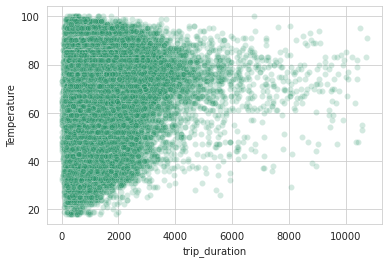

In [35]:
sns.scatterplot(x="trip_duration", y="Temperature", data=bike_sample, alpha=0.2)

<AxesSubplot:ylabel='Temperature'>

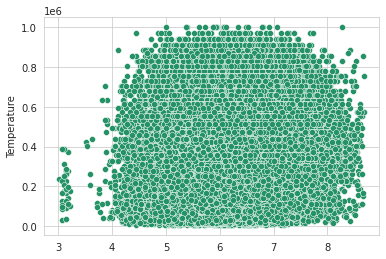

In [36]:
sns.scatterplot(x=boxcox(bike_sample["trip_duration"])[0], y=np.power(bike_sample["Temperature"], 3))

<AxesSubplot:xlabel='Temperature', ylabel='count'>

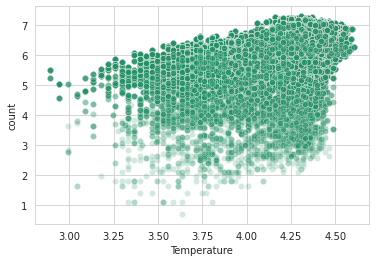

In [37]:
# Convert to categories
sns.scatterplot(x=(np.log(bike_sample["Temperature"])), y=np.log(np.power(bike_sample["count"], 1)), alpha=0.2)

<AxesSubplot:xlabel='Temperature', ylabel='count'>

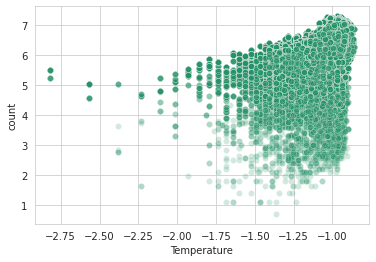

In [38]:
sns.scatterplot(x=np.log(np.log(np.log(np.log(bike_sample["Temperature"])))), y=(np.log(bike_sample["count"])), alpha=0.2)

In [39]:
temp_coefs = {}
for i in range(-5, 5, 1):
    temp_coefs[i] = np.corrcoef(np.power(bike_sample["trip_duration"], 0.2), np.power(bike_sample["Precipitation"], i))

for item in temp_coefs.items():
    print(item)

(-5, array([[ 1., nan],
       [nan, nan]]))
(-4, array([[ 1., nan],
       [nan, nan]]))
(-3, array([[ 1., nan],
       [nan, nan]]))
(-2, array([[ 1., nan],
       [nan, nan]]))
(-1, array([[ 1., nan],
       [nan, nan]]))
(0, array([[ 1., nan],
       [nan, nan]]))
(1, array([[ 1.        , -0.01029612],
       [-0.01029612,  1.        ]]))
(2, array([[ 1.        , -0.00306727],
       [-0.00306727,  1.        ]]))
(3, array([[ 1.00000000e+00, -4.28215542e-05],
       [-4.28215542e-05,  1.00000000e+00]]))
(4, array([[1.00000000e+00, 7.29334674e-04],
       [7.29334674e-04, 1.00000000e+00]]))


/home/jay/Classes/Apl-DS/virtual/lib/python3.9/site-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/jay/Classes/Apl-DS/virtual/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jay/Classes/Apl-DS/virtual/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [40]:
np.corrcoef(np.power(bike_sample["trip_duration"], 0.2), np.log(bike_sample["Temperature"]))

array([[1.        , 0.10743377],
       [0.10743377, 1.        ]])

<AxesSubplot:xlabel='count', ylabel='Temperature'>

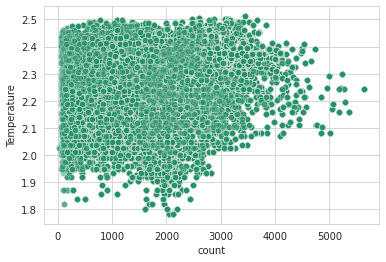

In [41]:
# Convert to categories
sns.scatterplot(x=np.power(taxi_sample["count"], 1), y=np.power(taxi_sample["Temperature"], 0.2), alpha=0.2)

In [42]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(bike_sample[["Temperature", "Dew Point", "Humidity", "Wind Speed", "Wind Gust", "Pressure"]])

In [44]:
pca_fit_df = pd.DataFrame(pca_fit, columns=[0, 1])

/home/jay/Classes/Apl-DS/virtual/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

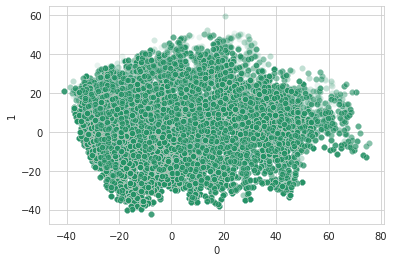

In [45]:
sns.scatterplot(pca_fit_df[0], pca_fit_df[1], alpha=0.1)

In [46]:
bike_sample.head(2)

,year,month,day,time_bin,PULocationID,DOLocationID,day_of_week,trip_duration,peak_hours,weather_pattern,count,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Precipitation
0,2021,7,195,18,74,141,4,1740,1,1,1215,85.0,70.0,61.0,12.0,0.0,30.1,0.0
1,2021,7,204,18,238,48,6,1728,1,1,802,79.0,54.0,42.0,9.0,0.0,30.0,0.0


In [47]:
bike_sample_anova = bike_sample.copy()
bike_sample_anova.columns = ['year', 'month', 'day', 'time_bin', 'PULocationID', 'DOLocationID',
       'day_of_week', 'trip_duration', 'peak_hours', 'weather_pattern',
       'count', 'Temperature', 'Dew_Point', 'Humidity', 'Wind_Speed',
       'Wind_Gust', 'Pressure', 'Precipitation']

bike_sample_anova.head(2)

,year,month,day,time_bin,PULocationID,DOLocationID,day_of_week,trip_duration,peak_hours,weather_pattern,count,Temperature,Dew_Point,Humidity,Wind_Speed,Wind_Gust,Pressure,Precipitation
0,2021,7,195,18,74,141,4,1740,1,1,1215,85.0,70.0,61.0,12.0,0.0,30.1,0.0
1,2021,7,204,18,238,48,6,1728,1,1,802,79.0,54.0,42.0,9.0,0.0,30.0,0.0


In [48]:
bike_sample_anova["trip_duration_reduced"] = bike_sample_anova["trip_duration"] ** (0.2)
bike_sample_anova.head(2)

,year,month,day,time_bin,PULocationID,DOLocationID,day_of_week,trip_duration,peak_hours,weather_pattern,count,Temperature,Dew_Point,Humidity,Wind_Speed,Wind_Gust,Pressure,Precipitation,trip_duration_reduced
0,2021,7,195,18,74,141,4,1740,1,1,1215,85.0,70.0,61.0,12.0,0.0,30.1,0.0,4.447437
1,2021,7,204,18,238,48,6,1728,1,1,802,79.0,54.0,42.0,9.0,0.0,30.0,0.0,4.441286


### Use an ANOVA model to test significance

#### Testing for bikes

In [49]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("trip_duration ~ Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation", data=bike_sample_anova).fit()

aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                     sum_sq        df          F    PR(>F)
Temperature    6.375244e+06       1.0  12.389568  0.000432
Dew_Point      7.135986e+05       1.0   1.386799  0.238948
Humidity       5.773029e+06       1.0  11.219233  0.000810
Wind_Speed     9.270634e+06       1.0  18.016434  0.000022
Wind_Gust      8.299771e+06       1.0  16.129670  0.000059
Pressure       5.059089e+06       1.0   9.831770  0.001716
Precipitation  1.497479e+06       1.0   2.910182  0.088024
Residual       8.250285e+10  160335.0        NaN       NaN


In [50]:
model2 = ols("trip_duration_reduced ~ Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation", data=bike_sample_anova).fit()

aov_table2 = sm.stats.anova_lm(model2, typ=2)
print(aov_table2)

                     sum_sq        df          F        PR(>F)
Temperature        2.825997       1.0  10.282402  1.343313e-03
Dew_Point          1.189454       1.0   4.327834  3.749551e-02
Humidity           5.353769       1.0  19.479712  1.017401e-05
Wind_Speed         5.179213       1.0  18.844589  1.418995e-05
Wind_Gust          6.888069       1.0  25.062269  5.556711e-07
Pressure           2.465363       1.0   8.970234  2.744554e-03
Precipitation      1.564554       1.0   5.692635  1.703741e-02
Residual       44066.186344  160335.0        NaN           NaN


In [51]:
bike_sample_anova["PULocationID"] = pd.Categorical(bike_sample_anova["PULocationID"])
bike_sample_anova["DOLocationID"] = pd.Categorical(bike_sample_anova["DOLocationID"])
bike_sample_anova["log_count"] = np.log(bike_sample_anova["count"])
bike_sample_anova.head(2)

,year,month,day,time_bin,PULocationID,DOLocationID,day_of_week,trip_duration,peak_hours,weather_pattern,count,Temperature,Dew_Point,Humidity,Wind_Speed,Wind_Gust,Pressure,Precipitation,trip_duration_reduced,log_count
0,2021,7,195,18,74,141,4,1740,1,1,1215,85.0,70.0,61.0,12.0,0.0,30.1,0.0,4.447437,7.102499
1,2021,7,204,18,238,48,6,1728,1,1,802,79.0,54.0,42.0,9.0,0.0,30.0,0.0,4.441286,6.687109


In [52]:
model3 = ols("trip_duration_reduced ~ PULocationID + DOLocationID + Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation + log_count", data=bike_sample_anova).fit()

aov_table3 = sm.stats.anova_lm(model3, typ=2)
print(aov_table3)

                     sum_sq        df           F        PR(>F)
PULocationID     772.546435      59.0   50.235333  0.000000e+00
DOLocationID     890.073020      59.0   57.877575  0.000000e+00
Temperature        1.238234       1.0    4.750502  2.929120e-02
Dew_Point          0.907603       1.0    3.482030  6.204041e-02
Humidity           2.948936       1.0   11.313632  7.695814e-04
Wind_Speed         1.597905       1.0    6.130384  1.328882e-02
Wind_Gust          2.599267       1.0    9.972124  1.589575e-03
Pressure           1.729498       1.0    6.635241  9.998953e-03
Precipitation      0.158252       1.0    0.607135  4.358697e-01
log_count         74.605502       1.0  286.224994  3.757968e-64
Residual       41760.835977  160216.0         NaN           NaN


In [53]:
model4 = ols("trip_duration_reduced ~ PULocationID + DOLocationID + Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation + count", data=bike_sample_anova).fit()

aov_table4 = sm.stats.anova_lm(model4, typ=2)
print(aov_table4)

                     sum_sq        df           F        PR(>F)
PULocationID     770.111604      59.0   50.107047  0.000000e+00
DOLocationID     885.403287      59.0   57.608460  0.000000e+00
Temperature        0.650537       1.0    2.497291  1.140443e-01
Dew_Point          1.338577       1.0    5.138551  2.340150e-02
Humidity           3.601135       1.0   13.824091  2.008140e-04
Wind_Speed         0.963602       1.0    3.699090  5.444393e-02
Wind_Gust          1.666680       1.0    6.398076  1.142536e-02
Pressure           1.717876       1.0    6.594608  1.022971e-02
Precipitation      0.379024       1.0    1.455004  2.277285e-01
count             99.642244       1.0  382.508112  4.450632e-85
Residual       41735.799235  160216.0         NaN           NaN


For bikes, the weather data is significant and the count column (without log) explains a lot more in the data. Beyond that, everything is significant for a trip distance that is normally adjusted (using power law ^ 0.2)

In [54]:
# Checking significance of the PCA formed columns
bike_sample_anova["pca_a"] = pca_fit_df[0]
bike_sample_anova["pca_b"] = pca_fit_df[1]

bike_sample_anova.head()

,year,month,day,time_bin,PULocationID,DOLocationID,day_of_week,trip_duration,peak_hours,weather_pattern,...,Dew_Point,Humidity,Wind_Speed,Wind_Gust,Pressure,Precipitation,trip_duration_reduced,log_count,pca_a,pca_b
0,2021,7,195,18,74,141,4,1740,1,1,...,70.0,61.0,12.0,0.0,30.1,0.0,4.447437,7.102499,-28.052572,-6.410805
1,2021,7,204,18,238,48,6,1728,1,1,...,54.0,42.0,9.0,0.0,30.0,0.0,4.441286,6.687109,-5.409982,-16.840140
2,2021,7,195,18,90,232,4,966,1,1,...,70.0,61.0,12.0,0.0,30.1,0.0,3.953625,7.102499,-28.052572,-6.410805
3,2021,7,204,18,237,263,6,321,1,1,...,54.0,42.0,9.0,0.0,30.0,0.0,3.171765,6.687109,-5.409982,-16.840140
4,2021,7,195,18,229,163,4,3061,1,1,...,70.0,61.0,12.0,0.0,30.1,0.0,4.979350,7.102499,-28.052572,-6.410805


In [55]:
model_bike_pca = ols("trip_duration_reduced ~ PULocationID + DOLocationID + Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation + count + pca_a + pca_b", data=bike_sample_anova).fit()

aov_table_bike_pca = sm.stats.anova_lm(model_bike_pca, typ=2)
print(aov_table_bike_pca)

                     sum_sq        df           F         PR(>F)
PULocationID     770.111604      59.0   50.107047   0.000000e+00
DOLocationID     885.403287      59.0   57.608460   0.000000e+00
Temperature       43.940559       1.0  168.679665   1.503292e-38
Dew_Point         39.366904       1.0  151.122249   1.021738e-34
Humidity          40.925657       1.0  157.106013   5.045596e-36
Wind_Speed         3.487018       1.0   13.386015   2.535886e-04
Wind_Gust         38.770017       1.0  148.830910   3.233732e-34
Pressure           1.706374       1.0    6.550453   1.048665e-02
Precipitation      0.379024       1.0    1.455004   2.277285e-01
count             99.642244       1.0  382.508112   4.450632e-85
pca_a             45.086102       1.0  173.077190   1.650559e-39
pca_b            181.591472       1.0  697.096012  2.732097e-153
Residual       41735.799235  160216.0         NaN            NaN


In [56]:
bike_sample_anova["time_bin"] = pd.Categorical(bike_sample_anova["time_bin"])
bike_sample_anova["month"] = pd.Categorical(bike_sample_anova["month"])
bike_sample_anova["day_of_week"] = pd.Categorical(bike_sample_anova["day_of_week"])
bike_sample_anova["weather_pattern"] = pd.Categorical(bike_sample_anova["weather_pattern"])

model_bike_cat = ols("trip_duration_reduced ~ PULocationID + DOLocationID + Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation + count + time_bin +  month + day_of_week + weather_pattern", data=bike_sample_anova).fit()

aov_table_bike_cat = sm.stats.anova_lm(model_bike_cat, typ=2)
print(aov_table_bike_cat)

                       sum_sq        df           F         PR(>F)
PULocationID       777.148762      59.0   50.833132   0.000000e+00
DOLocationID       891.000597      59.0   58.280156   0.000000e+00
time_bin           195.507959      23.0   32.804342  3.290844e-144
month               24.410428      11.0    8.564015   2.518630e-15
day_of_week          9.753183       4.0    9.409816   1.332591e-07
weather_pattern      5.383372       2.0   10.387693   3.083008e-05
Temperature          1.446189       1.0    5.581100   1.815651e-02
Dew_Point            0.000820       1.0    0.003165   9.551331e-01
Humidity             0.103703       1.0    0.400209   5.269821e-01
Wind_Speed           0.023549       1.0    0.090881   7.630603e-01
Wind_Gust            0.553115       1.0    2.134568   1.440130e-01
Pressure             0.298246       1.0    1.150983   2.833452e-01
Precipitation        0.414378       1.0    1.599156   2.060247e-01
count               69.333753       1.0  267.571240   4.296283

#### Testing for taxis

In [57]:
taxi_sample_anova = taxi_sample.copy()
taxi_sample_anova.columns = ['year', 'month', 'day', 'time_bin', 'PULocationID', 'DOLocationID',
       'day_of_week', 'trip_duration', 'peak_hours', 'weather_pattern',
       'count', 'Temperature', 'Dew_Point', 'Humidity', 'Wind_Speed',
       'Wind_Gust', 'Pressure', 'Precipitation']

taxi_sample_anova["PULocationID"] = pd.Categorical(taxi_sample_anova["PULocationID"])
taxi_sample_anova["DOLocationID"] = pd.Categorical(taxi_sample_anova["DOLocationID"])

taxi_sample_anova["time_bin"] = pd.Categorical(taxi_sample_anova["time_bin"])
taxi_sample_anova["month"] = pd.Categorical(taxi_sample_anova["month"])
taxi_sample_anova["day_of_week"] = pd.Categorical(taxi_sample_anova["day_of_week"])
taxi_sample_anova["weather_pattern"] = pd.Categorical(taxi_sample_anova["weather_pattern"])

taxi_sample_anova["log_count"] = np.log(taxi_sample_anova["count"])
taxi_sample_anova["trip_duration_reduced"] = np.power(taxi_sample_anova["trip_duration"], 0.2)

taxi_sample_anova.head(2)

,year,month,day,time_bin,PULocationID,DOLocationID,day_of_week,trip_duration,peak_hours,weather_pattern,count,Temperature,Dew_Point,Humidity,Wind_Speed,Wind_Gust,Pressure,Precipitation,log_count,trip_duration_reduced
0,2021,12,361,10,261,113,2,756,1,0,2114,36.0,21.0,55.0,10.0,0.0,30.1,0.0,7.656337,3.764474
1,2021,12,361,10,90,164,2,560,1,0,2114,36.0,21.0,55.0,10.0,0.0,30.1,0.0,7.656337,3.545174


In [58]:
model5 = ols("trip_duration ~ Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation", data=taxi_sample_anova).fit()

aov_table5 = sm.stats.anova_lm(model5, typ=2)
print(aov_table5)

                     sum_sq        df           F        PR(>F)
Temperature    2.275205e+07       1.0  116.358539  3.985086e-27
Dew_Point      2.959715e+07       1.0  151.365740  8.786194e-35
Humidity       3.088737e+07       1.0  157.964177  3.177720e-36
Wind_Speed     2.181234e+06       1.0   11.155264  8.379763e-04
Wind_Gust      4.247809e+06       1.0   21.724142  3.148584e-06
Pressure       4.657649e+07       1.0  238.201460  9.888526e-54
Precipitation  4.221828e+06       1.0   21.591269  3.374413e-06
Residual       1.470611e+11  752100.0         NaN           NaN


In [59]:
model6 = ols("trip_duration_reduced ~ Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation", data=taxi_sample_anova).fit()

aov_table6 = sm.stats.anova_lm(model6, typ=2)
print(aov_table6)

                      sum_sq        df           F        PR(>F)
Temperature        17.476750       1.0  104.709037  1.419807e-24
Dew_Point          22.294836       1.0  133.575794  6.805850e-31
Humidity           21.665834       1.0  129.807232  4.541447e-30
Wind_Speed          2.639190       1.0   15.812265  6.995414e-05
Wind_Gust           2.887024       1.0   17.297124  3.197058e-05
Pressure           34.797492       1.0  208.483375  2.985999e-47
Precipitation       4.439965       1.0   26.601309  2.501375e-07
Residual       125531.321781  752100.0         NaN           NaN


In [60]:
taxi_sample_anova["trip_duration_reduced_four"] = np.power(taxi_sample_anova["trip_duration"], 0.25)

taxi_sample_anova.head(2)

,year,month,day,time_bin,PULocationID,DOLocationID,day_of_week,trip_duration,peak_hours,weather_pattern,...,Temperature,Dew_Point,Humidity,Wind_Speed,Wind_Gust,Pressure,Precipitation,log_count,trip_duration_reduced,trip_duration_reduced_four
0,2021,12,361,10,261,113,2,756,1,0,...,36.0,21.0,55.0,10.0,0.0,30.1,0.0,7.656337,3.764474,5.243611
1,2021,12,361,10,90,164,2,560,1,0,...,36.0,21.0,55.0,10.0,0.0,30.1,0.0,7.656337,3.545174,4.864599


In [61]:
model7 = ols("trip_duration_reduced_four ~ Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation", data=taxi_sample_anova).fit()

aov_table7 = sm.stats.anova_lm(model7, typ=2)
print(aov_table7)

                      sum_sq        df           F        PR(>F)
Temperature        53.313637       1.0  106.156476  6.839735e-25
Dew_Point          68.072189       1.0  135.543253  2.526978e-31
Humidity           66.431613       1.0  132.276587  1.309311e-30
Wind_Speed          7.910689       1.0   15.751521  7.223654e-05
Wind_Gust           8.893184       1.0   17.707836  2.575933e-05
Pressure          106.268325       1.0  211.598225  6.247524e-48
Precipitation      13.348882       1.0   26.579883  2.529268e-07
Residual       377717.757891  752100.0         NaN           NaN


In [62]:
model8 = ols("trip_duration_reduced_four ~ Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation + count", data=taxi_sample_anova).fit()

aov_table8 = sm.stats.anova_lm(model8, typ=2)
print(aov_table8)

                      sum_sq        df             F        PR(>F)
Temperature        85.456025       1.0    174.532516  7.651402e-40
Dew_Point          86.898724       1.0    177.479034  1.739675e-40
Humidity           42.780164       1.0     87.372770  9.011296e-21
Wind_Speed         66.872357       1.0    136.577856  1.500906e-31
Wind_Gust          13.163788       1.0     26.885279  2.159527e-07
Pressure           97.898430       1.0    199.944465  2.176600e-45
Precipitation       6.675329       1.0     13.633469  2.222047e-04
count            9468.947753       1.0  19339.060820  0.000000e+00
Residual       368248.810138  752099.0           NaN           NaN


In [63]:
model9 = ols("trip_duration_reduced_four ~ Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation + log_count", data=taxi_sample_anova).fit()

aov_table9 = sm.stats.anova_lm(model9, typ=2)
print(aov_table9)

                      sum_sq        df             F        PR(>F)
Temperature       103.434433       1.0    210.944680  8.674589e-48
Dew_Point         108.974995       1.0    222.244129  2.979104e-50
Humidity           67.124414       1.0    136.893852  1.280128e-31
Wind_Speed         54.390108       1.0    110.923448  6.175682e-26
Wind_Gust          16.013659       1.0     32.658334  1.099087e-08
Pressure           88.132080       1.0    179.736988  5.591927e-41
Precipitation       5.253089       1.0     10.713175  1.063801e-03
log_count        8934.180835       1.0  18220.411346  0.000000e+00
Residual       368783.577056  752099.0           NaN           NaN


In [64]:
taxi_sample_anova["trip_duration_reduced_three"] = np.power(taxi_sample_anova["trip_duration"], 0.33)
model10 = ols("trip_duration_reduced_three ~ Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation + count", data=taxi_sample_anova).fit()

aov_table10 = sm.stats.anova_lm(model10, typ=2)
print(aov_table10)

                     sum_sq        df             F        PR(>F)
Temperature    4.346089e+02       1.0    177.716490  1.543940e-40
Dew_Point      4.429609e+02       1.0    181.131699  2.774063e-41
Humidity       2.208621e+02       1.0     90.313021  2.038743e-21
Wind_Speed     3.349569e+02       1.0    136.967634  1.233445e-31
Wind_Gust      6.778609e+01       1.0     27.718496  1.403531e-07
Pressure       5.001144e+02       1.0    204.502437  2.205198e-46
Precipitation  3.300679e+01       1.0     13.496850  2.389808e-04
count          4.776792e+04       1.0  19532.840027  0.000000e+00
Residual       1.839272e+06  752099.0           NaN           NaN


In [66]:
model11 = ols("trip_duration_reduced_three ~ PULocationID + DOLocationID + Temperature + Precipitation + count", data=taxi_sample_anova).fit()

aov_table11 = sm.stats.anova_lm(model11, typ=2)
print(aov_table11)

                     sum_sq        df             F    PR(>F)
PULocationID   3.153648e+04      59.0    229.353140  0.000000
DOLocationID   4.836469e+04      59.0    351.738504  0.000000
Temperature    1.580607e+00       1.0      0.678215  0.410202
Precipitation  5.023662e+01       1.0     21.555789  0.000003
count          5.233138e+04       1.0  22454.619126  0.000000
Residual       1.752533e+06  751986.0           NaN       NaN


In [68]:
model12 = ols("trip_duration_reduced_three ~ count + day_of_week + month + weather_pattern ", data=taxi_sample_anova).fit()

aov_table12 = sm.stats.anova_lm(model12, typ=2)
print(aov_table12)

                       sum_sq        df             F         PR(>F)
day_of_week      1.338243e+03       4.0    136.947792  3.394773e-117
month            2.788321e+03      11.0    103.760075  1.071304e-237
weather_pattern  2.052481e+02       2.0     42.007748   5.718550e-19
count            3.461400e+04       1.0  14168.764776   0.000000e+00
Residual         1.837338e+06  752089.0           NaN            NaN


: 

### Testing average trip distances

In [28]:
bikes.head(1)

[Row(year=2021, month=7, day=195, time_bin=18, PULocationID=43, DOLocationID=48, day_of_week=4, trip_duration=1598, peak_hours=1, weather_pattern=1, count=1215, Temperature=85.0, Dew Point=70.0, Humidity=61.0, Wind Speed=12.0, Wind Gust=0.0, Pressure=30.1, Precipitation=0.0)]

In [29]:
taxis.head(1)

[Row(year=2021, month=12, day=361, time_bin=10, PULocationID=68, DOLocationID=170, day_of_week=2, trip_duration=834, peak_hours=1, weather_pattern=0, count=2114, Temperature=36.0, Dew Point=21.0, Humidity=55.0, Wind Speed=10.0, Wind Gust=0.0, Pressure=30.1, Precipitation=0.0)]

In [30]:
LOCATION_NO = 239
south_upper_west_bikes = bikes.filter(col("PULocationID") == LOCATION_NO)
south_upper_west_taxis = taxis.filter(col("PULocationID") == LOCATION_NO)

print(south_upper_west_bikes.count())
print(south_upper_west_taxis.count())

53197
369952


Checking between 6 am to 9 am vs. 6 pm to 9 pm

In [49]:
south_upper_west_taxis_morning = south_upper_west_taxis.filter((col("time_bin") >= 6) & (col("time_bin") < 9)).groupBy("DOLocationID").avg("trip_duration").toPandas()
south_upper_west_bikes_morning = south_upper_west_bikes.filter((col("time_bin") >= 6) & (col("time_bin") < 9)).groupBy("DOLocationID").avg("trip_duration").toPandas()

south_upper_west_bikes_morning.head()

,DOLocationID,avg(trip_duration)
0,113,1817.725490
1,237,745.768786
2,262,873.088235
3,50,775.682692
4,229,1092.326087


In [50]:
south_upper_west_taxis_morning.head()

,DOLocationID,avg(trip_duration)
0,113,1547.720317
1,237,798.722377
2,202,1842.458333
3,262,941.935430
4,50,601.909276


In [51]:
south_upper_west_bikes_morning.columns = ["DO_ID", "avg_time_for_bikes"]
south_upper_west_taxis_morning.columns = ["DO_ID", "avg_time_for_taxis"]

merged = south_upper_west_taxis_morning.merge(south_upper_west_bikes_morning, on="DO_ID", how="left")
merged.head()

,DO_ID,avg_time_for_taxis,avg_time_for_bikes
0,113,1547.720317,1817.725490
1,237,798.722377,745.768786
2,202,1842.458333,NaN
3,262,941.935430,873.088235
4,50,601.909276,775.682692


In [52]:
merged.count()

DO_ID                 59
avg_time_for_taxis    59
avg_time_for_bikes    58
dtype: int64

In [53]:
merged = merged.dropna()
merged.count()

DO_ID                 58
avg_time_for_taxis    58
avg_time_for_bikes    58
dtype: int64

In [54]:
merged["difference"] = merged["avg_time_for_taxis"] - merged["avg_time_for_bikes"]
merged.head()

,DO_ID,avg_time_for_taxis,avg_time_for_bikes,difference
0,113,1547.720317,1817.725490,-270.005174
1,237,798.722377,745.768786,52.953591
3,262,941.935430,873.088235,68.847195
4,50,601.909276,775.682692,-173.773416
5,229,1140.940510,1092.326087,48.614423


In [55]:
merged["scaled"] = merged["difference"] / merged["difference"].abs().max()
merged.head()

,DO_ID,avg_time_for_taxis,avg_time_for_bikes,difference,scaled
0,113,1547.720317,1817.725490,-270.005174,-0.233278
1,237,798.722377,745.768786,52.953591,0.045751
3,262,941.935430,873.088235,68.847195,0.059482
4,50,601.909276,775.682692,-173.773416,-0.150136
5,229,1140.940510,1092.326087,48.614423,0.042002


In [40]:
import folium
import geopandas as gpd

In [41]:
zones = pd.read_csv("../data/raw/taxi_zones/taxi_zones_lookup.csv")
sf = gpd.read_file("../data/raw/taxi_zones/taxi_zones.shp")

sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on="LocationID", how="inner")
)
gdf.head(2)

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."


In [56]:
_map = folium.Map(location=[40.7793, -73.974], tiles="Stamen Terrain", zoom_start=11)

manhattan = gdf[gdf["Borough"] == "Manhattan"]
geoJSON = manhattan[['LocationID', 'geometry']].drop_duplicates("LocationID").to_json()

# refer to the folium documentations on how to plot aggregated data.
_map.add_child(folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
))

_map.save('../plots/foliumChoroplethMap.html')
_map

In [69]:
m = folium.Map(location=[40.77, -73.97], tiles="Stamen Terrain", zoom_start=11)
selected = merged[['DO_ID','scaled']]
selected.loc[len(selected.index)] = [239.0, 1.0]

# geoJSON = manhattan[['LocationID', 'geometry']].drop_duplicates("LocationID").to_json()

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=selected.dropna(), # data source
    columns=['DO_ID','scaled'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='RdYlBu', # color scheme
    nan_fill_color='black',
    legend_name='Average Trip Duration Ratio [Taxis - Bikes]'
)

c.add_to(m)

# Standardize the column!!!
# And then do the same for 8 pm
# Take a group of peak hours
# Take the are to the left of Central Park as a centre
m

Checking between 6 pm to 9 pm

In [60]:
south_upper_west_taxis_evening = south_upper_west_taxis.filter((col("time_bin") >= 18) & (col("time_bin") < 21)).groupBy("DOLocationID").avg("trip_duration").toPandas()
south_upper_west_bikes_evening = south_upper_west_bikes.filter((col("time_bin") >= 18) & (col("time_bin") < 21)).groupBy("DOLocationID").avg("trip_duration").toPandas()

south_upper_west_bikes_evening.head()

,DOLocationID,avg(trip_duration)
0,113,1897.196721
1,237,859.885496
2,262,1139.875000
3,50,878.798387
4,229,1307.094340


In [61]:
south_upper_west_taxis_evening.head()

,DOLocationID,avg(trip_duration)
0,113,1152.649635
1,237,557.854839
2,202,1416.000000
3,262,671.186235
4,50,510.799687


In [62]:
south_upper_west_bikes_evening.columns = ["DO_ID", "avg_time_for_bikes"]
south_upper_west_taxis_evening.columns = ["DO_ID", "avg_time_for_taxis"]

merged_pm = south_upper_west_taxis_evening.merge(south_upper_west_bikes_evening, on="DO_ID", how="left")
merged_pm.head()

,DO_ID,avg_time_for_taxis,avg_time_for_bikes
0,113,1152.649635,1897.196721
1,237,557.854839,859.885496
2,202,1416.000000,6449.500000
3,262,671.186235,1139.875000
4,50,510.799687,878.798387


In [63]:
merged_pm.count()

DO_ID                 58
avg_time_for_taxis    58
avg_time_for_bikes    58
dtype: int64

In [64]:
merged_pm.dropna().count()

DO_ID                 58
avg_time_for_taxis    58
avg_time_for_bikes    58
dtype: int64

In [65]:
merged_pm["difference"] = merged_pm["avg_time_for_taxis"] - merged_pm["avg_time_for_bikes"]
merged_pm.head()

,DO_ID,avg_time_for_taxis,avg_time_for_bikes,difference
0,113,1152.649635,1897.196721,-744.547086
1,237,557.854839,859.885496,-302.030657
2,202,1416.000000,6449.500000,-5033.500000
3,262,671.186235,1139.875000,-468.688765
4,50,510.799687,878.798387,-367.998700


In [66]:
merged_pm["scaled"] = merged_pm["difference"] / merged_pm["difference"].abs().max()
merged_pm.head()

,DO_ID,avg_time_for_taxis,avg_time_for_bikes,difference,scaled
0,113,1152.649635,1897.196721,-744.547086,-0.147918
1,237,557.854839,859.885496,-302.030657,-0.060004
2,202,1416.000000,6449.500000,-5033.500000,-1.000000
3,262,671.186235,1139.875000,-468.688765,-0.093114
4,50,510.799687,878.798387,-367.998700,-0.073110


In [68]:
m = folium.Map(location=[40.77, -73.97], tiles="Stamen Terrain", zoom_start=11)
selected = merged_pm[['DO_ID','scaled']]
selected.loc[len(selected.index)] = [239.0, 1.0]

# geoJSON = manhattan[['LocationID', 'geometry']].drop_duplicates("LocationID").to_json()

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=selected.dropna(), # data source
    columns=['DO_ID','scaled'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='RdYlBu', # color scheme
    nan_fill_color='black',
    legend_name='Average Trip Duration Ratio [Taxis - Bikes]'
)

c.add_to(m)

# Standardize the column!!!
# And then do the same for 8 pm
# Take a group of peak hours
# Take the are to the left of Central Park as a centre
m

/tmp/ipykernel_4657/3842344741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected.loc[len(selected.index)] = [239.0, 1.0]
